# Feature Engineering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing and Loading Libraries

Importing important libraries:

In [2]:
# Loading and plotting images
import os
import cv2
from google.colab.patches import cv2_imshow
from glob import glob
from tqdm import tqdm

# Data Manipulation
import numpy as np
from scipy.signal import medfilt2d

# More Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Image Sample

Folders locations:

In [19]:
MASK_ROOT = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Masks"
SAVE_ROOT = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img"

Files names:

In [20]:
def read_image_filenames(path):
    extensions = ["*.tif", "*.tiff", "*.jpeg", "*.jpg", "*.png"]
    image_filenames = []
    for ext in extensions:
        image_filenames.extend(glob(os.path.join(path, ext)))
    return image_filenames

In [21]:
images_filenames = read_image_filenames(SAVE_ROOT)
images_filenames[:10]

['/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078110.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078111.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078129.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078130.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078148.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078149.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078218.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078219.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078237.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078238.png']

In [18]:
print(f"There are {len(images_filenames)} images in the project.")

There are 0 images in the project.


Load sample image:

In [7]:
def read_image(image_filename):
    return cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE) 

(128, 128)


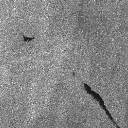

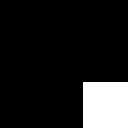

In [26]:
# fil = images_filenames[0]
fil = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img/4078110.png"
film = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Masks/4078110.png"

img = read_image(fil)
img = (img / np.max(img)) * 255
# img = img[:,:,0]
mask = read_image(film)

print(img.shape)
cv2_imshow(img)
cv2_imshow(mask)

# Data Augmentation

The first augmentation is to create an image with the cumulative sums in four directions and average them.

0.0


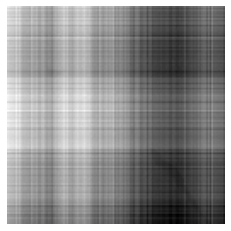

In [27]:
test = np.cumsum(img, axis = 0) + np.cumsum(img, axis = 1) + np.flipud(np.cumsum(np.flipud(img), axis = 0)) + np.fliplr(np.cumsum(np.fliplr(img), axis = 1))

img_c = test/np.max(test)
img_c = (img_c - np.min(img_c))
img_c = (img_c / np.max(img_c)) * 255

print(np.min(img_c))
plt.imshow(img_c, cmap = "gray")
plt.axis('off')
plt.show()

The second augmentation is to apply a 2D median filter to the image.

165.0


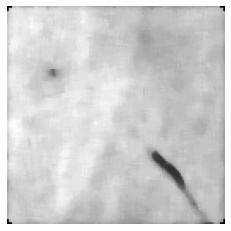

In [30]:
img_m = medfilt2d(img, 7)

print(np.max(img_m))

plt.imshow(img_m, cmap = "gray")
plt.axis('off')
plt.show()

# Augmentation as color channel

Now, let's include each augmentation as a color channel to the grayscale image.

In [31]:
img.shape

(128, 128)

In [32]:
img_rgb = np.expand_dims(img, axis = 2)
img_m2 = np.expand_dims(img_m, axis = 2)
img_c2 = np.expand_dims(img_c, axis = 2)

In [33]:
img_rgb.shape

(128, 128, 1)

In [34]:
img_rgb = np.concatenate((img_rgb, img_m2, img_c2), axis = 2)

img_rgb.shape

(128, 128, 3)

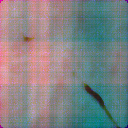

In [38]:
cv2_imshow(img_rgb)

# Functions

Convert the processes above to functions:

In [39]:
# Function to read and normalize input image
def read_norm_image(file_name):
  
  # Read the File as grayscale
  img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

  # Normalize image
  img = (img / np.max(img)) * 255

  return img

In [40]:
# Function to calculate the 4 direction cumulative sums
def four_direction_cumsum(img, mfilter):

  # Calculate cumulative sums
  img_c = np.cumsum(img, axis = 0) + np.cumsum(img, axis = 1) + np.flipud(np.cumsum(np.flipud(img), axis = 0)) + np.fliplr(np.cumsum(np.fliplr(img), axis = 1))

  # Normalize cumsums
  img_c = img_c/np.max(img_c)
  img_c = (img_c - np.min(img_c))
  img_c = (img_c / np.max(img_c)) * 255

  # Median filter to final image
  img_c = medfilt2d(img_c, mfilter)

  return img_c

In [41]:
# Function to apply all the augmentations and concatenate them as color channels
def img_augmentation(file_name, mfilter = 3):
  
  # Import median filter from scipy
  from scipy.signal import medfilt2d

  # Read and normalize image
  img = read_norm_image(file_name)

  # Median filter of the image
  img_m = medfilt2d(img, kernel_size = mfilter)

  # Four direction cumsum
  img_c = four_direction_cumsum(img, mfilter = mfilter)

  # Expand dimensions
  # img = np.expand_dims(img, axis = 2)
  img_m = np.expand_dims(img_m, axis = 2)
  img_c = np.expand_dims(img_c, axis = 2)

  # Concatenate images
  return np.concatenate((img, img_m, img_c), axis = 2)

Test function:

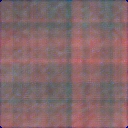

In [47]:
img = img_augmentation(images_filenames[150], mfilter = 5)

cv2_imshow(img)

# Create new images

Apply the augmentation to all images and save to disk.

In [48]:
def read_image_filenames(path):
    extensions = ["*.tif", "*.tiff", "*.jpeg", "*.jpg", "*.png"]
    image_filenames = []
    for ext in extensions:
        image_filenames.extend(glob(os.path.join(path, ext)))
    return image_filenames

In [ ]:
files_folder = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Sat_Img"
augs_folder = "/content/drive/MyDrive/Satellite_oil_spill_identification/Data/128/Aug_Img"

files = read_image_filenames(files_folder)
files[:10]

['/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819016.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819020.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819021.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819022.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819023.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819029.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819030.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819031.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819032.png',
 '/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/1819038.png']

Creating and saving images to disk:

In [ ]:
def aug_image_disk(image_filename, new_image_folder = augs_folder, mfilter = 7):

  # Creating metafile info
  image_number = int(os.path.splitext(os.path.basename(image_filename))[0])

  # Augmented image
  img = img_augmentation(image_filename, mfilter = mfilter)

  # Saving augmented image to disk
  cv2.imwrite(new_image_folder + f"/{image_number}.png", img)

  return img


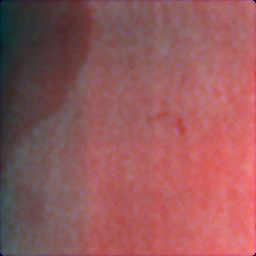

In [ ]:
img = aug_image_disk('/content/drive/MyDrive/Satellite_oil_spill_identification/Data/256/Sat_Img/2012.png')

cv2_imshow(img)

Going through all images:

In [ ]:
for filename in tqdm(files):
  img = aug_image_disk(filename)

  2%|▏         | 349/16214 [04:50<3:31:47,  1.25it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
100%|██████████| 16214/16214 [3:19:53<00:00,  1.35it/s]
